In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

# --- Define RHS network architecture ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

    def __call__(self, P, H, z):
        x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
        return self.mlp(x)

ys_list = []
for i in range(1):
    # --- Load trained model ---
    model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_log_less_dat_%s.eqx" %i
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    # --- Load H(z) and P(z) initial condition ---
    Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/Hz_all_reduced.npy")     # (30000, 100)
    pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/pk_nl_all_reduced.npy")  # (30000, 100, 262)
    z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/z.npy")          # (100,)

    # Use first sample as reference
    Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
    z_grid_rev = z_grid[::-1]       # high → low redshift

    # Interpolated function H(z), valid for decreasing z
    def H_func(z):
        return jnp.interp(z, z_grid_rev, Hz_ref)

    # Initial condition at z_max
    P0 = pk_all[28, -1]              
    y0 = jnp.log(jnp.array(P0))  # ✅ integrate log(P)


    # Time range: high z to low z
    z0 = float(z_grid[-1])          # e.g., z = 5
    z1 = float(z_grid[0])           # e.g., z = 0
    ts = jnp.linspace(z0, z1, 100)  # forward in time

    # --- Define RHS for ODE
    def rhs(z, P, args):
        model, H_fn = args
        H_z = jnp.atleast_1d(H_fn(z))
        return model(P, H_z, z)

    # --- Solve ODE
    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,  # negative because z is decreasing
        y0=y0,
        args=(model, H_func),
        saveat=saveat
    )

    print("Integrated P(z) shape (forward in time):", sol.ys.shape)
    Pz = jnp.exp(sol.ys)
    ys_list.append(Pz)



Integrated P(z) shape (forward in time): (100, 262)


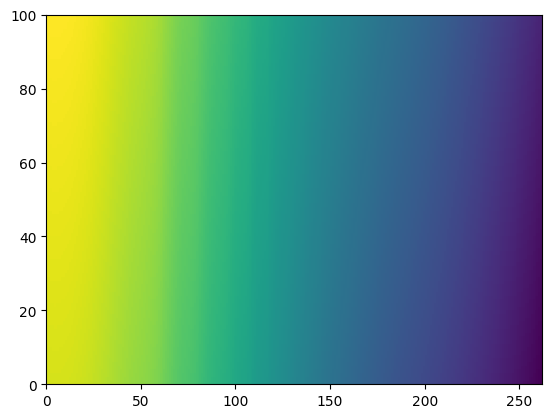

In [2]:
from matplotlib import pyplot as plt
plt.pcolormesh(sol.ys)

In [3]:
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/batched"
k = np.load(parent_dir + "/k.npy")  # (262,)'')

Text(0.5, 1.0, 'z=0.5')

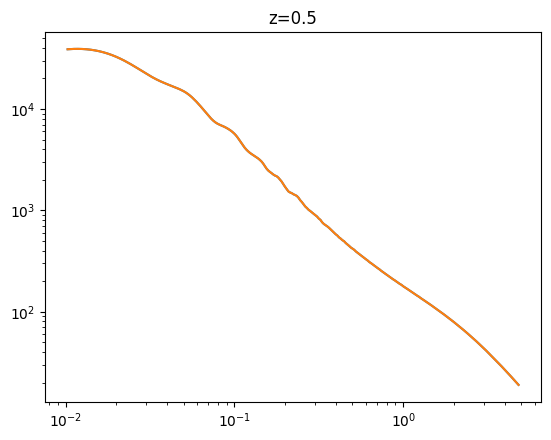

In [4]:
plt.plot(k, Pz[0])
plt.plot(k, pk_all[:,::-1][28, 0])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.5')



Text(0.5, 1.0, 'z=0')

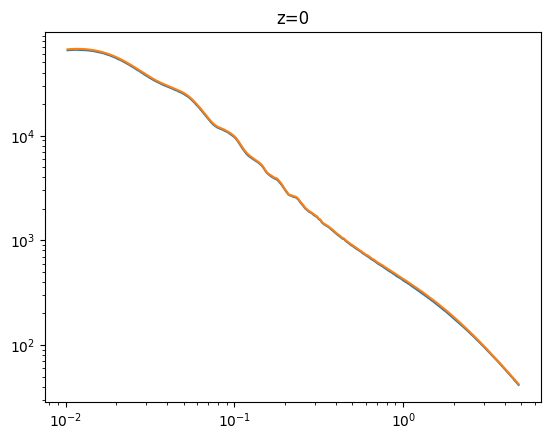

In [5]:
plt.plot(k, Pz[99])
plt.plot(k, pk_all[:,::-1][28, 99])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0')

In [6]:
combined = np.average(np.array(ys_list), axis = 0)
print (np.shape(combined))

(100, 262)


Text(0.5, 1.0, 'z=0')

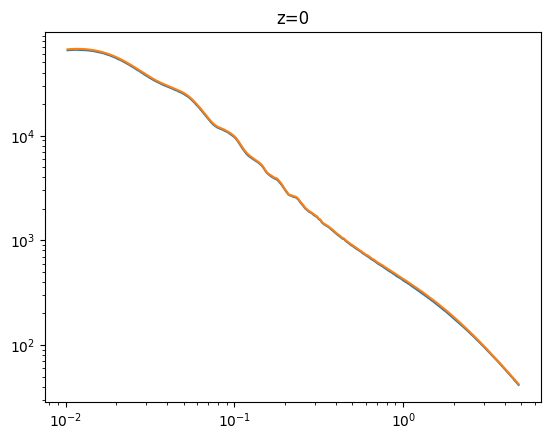

In [7]:
plt.plot(k, combined[99])
plt.plot(k, pk_all[:,::-1][28, 99])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0')

[6.54151172e+04 6.56832266e+04 6.58004766e+04 6.60016484e+04
 6.60694766e+04 6.59586094e+04 6.58057422e+04 6.58137812e+04
 6.56407734e+04 6.53766953e+04 6.50542188e+04 6.46802031e+04
 6.43223164e+04 6.37153320e+04 6.30539766e+04 6.24540742e+04
 6.18522109e+04 6.11455469e+04 6.01283203e+04 5.92926172e+04
 5.84162578e+04 5.72006211e+04 5.62565312e+04 5.49994336e+04
 5.37797109e+04 5.27364492e+04 5.15031680e+04 5.01396758e+04
 4.88878008e+04 4.76949648e+04 4.62490234e+04 4.50857266e+04
 4.36867070e+04 4.24290742e+04 4.13623359e+04 4.00293164e+04
 3.88178398e+04 3.76677344e+04 3.66708320e+04 3.55709062e+04
 3.46304258e+04 3.36724961e+04 3.29279688e+04 3.21447695e+04
 3.14540254e+04 3.07016074e+04 3.01250762e+04 2.95512793e+04
 2.89346367e+04 2.84609863e+04 2.78502773e+04 2.72684766e+04
 2.68193105e+04 2.61351816e+04 2.56617949e+04 2.50099375e+04
 2.43001074e+04 2.35633008e+04 2.27149355e+04 2.17436230e+04
 2.07671113e+04 1.96988438e+04 1.87840273e+04 1.77941660e+04
 1.68091250e+04 1.584941

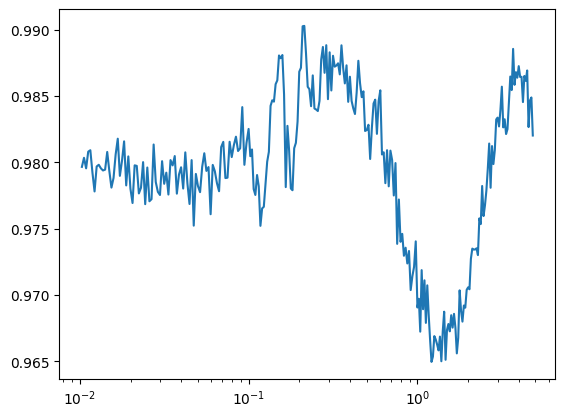

In [8]:
plt.plot(k, combined[99] / pk_all[:,::-1][28, 99])
plt.xscale('log')

print(combined[99])

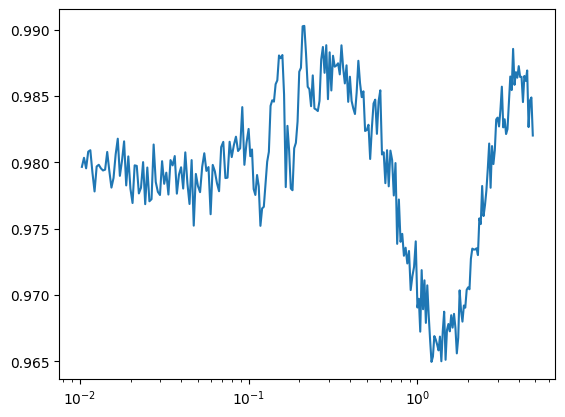

In [9]:
plt.plot(k, ys_list[0][99] / pk_all[:,::-1][28, 99])
plt.xscale('log')

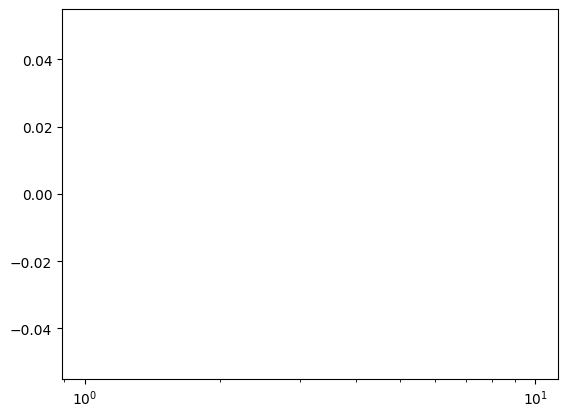

In [ ]:
plt.plot(k, sol.ys[99] / pk_all[:,::-1][28, 99])
plt.xscale('log')


Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)


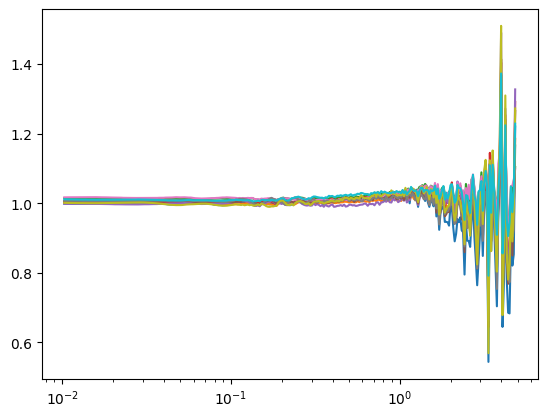

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

for ii in range(10):
    # --- Define RHS network architecture ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, z):
            x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- Load trained model ---
    model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_low_z.eqx"
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    # --- Load H(z) and P(z) initial condition ---
    Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/Hz_all.npy")     # (30000, 100)
    pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/pk_nl_all.npy")  # (30000, 100, 262)
    z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/z.npy")          # (100,)

    # Use first sample as reference
    Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
    z_grid_rev = z_grid[::-1]       # high → low redshift

    # Interpolated function H(z), valid for decreasing z
    def H_func(z):
        return jnp.interp(z, z_grid_rev, Hz_ref)

    # Initial condition at z_max
    P0 = pk_all[ii, -1]              # corresponds to highest redshift z = z_grid[-1]

    # Time range: high z to low z
    z0 = float(z_grid[-1])          # e.g., z = 5
    z1 = float(z_grid[0])           # e.g., z = 0
    ts = jnp.linspace(z0, z1, 100)  # forward in time

    # --- Define RHS for ODE
    def rhs(z, P, args):
        model, H_fn = args
        H_z = jnp.atleast_1d(H_fn(z))
        return model(P, H_z, z)

    # --- Solve ODE
    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,  # negative because z is decreasing
        y0 = jnp.log(jnp.array(P0)),
        args=(model, H_func),
        saveat=saveat
    )

    print("Integrated P(z) shape (forward in time):", sol.ys.shape)
    plt.plot(k, sol.ys[99] / pk_all[:,::-1][ii, 99])
    plt.xscale('log')


Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)


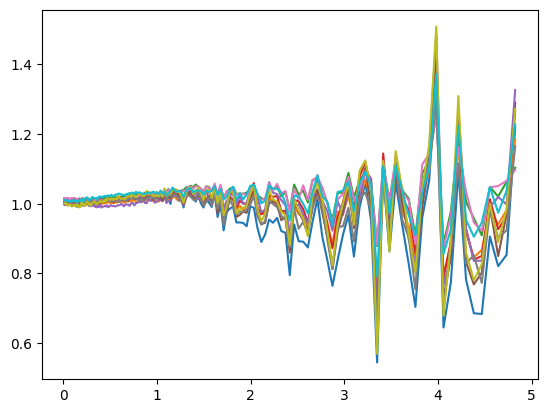

In [70]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

for ii in range(10):
    # --- Define RHS network architecture ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, z):
            x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- Load trained model ---
    model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_low_z.eqx"
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    # --- Load H(z) and P(z) initial condition ---
    Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/Hz_all.npy")     # (30000, 100)
    pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/pk_nl_all.npy")  # (30000, 100, 262)
    z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/z.npy")          # (100,)

    # Use first sample as reference
    Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
    z_grid_rev = z_grid[::-1]       # high → low redshift

    # Interpolated function H(z), valid for decreasing z
    def H_func(z):
        return jnp.interp(z, z_grid_rev, Hz_ref)

    # Initial condition at z_max
    P0 = pk_all[ii, -1]              # corresponds to highest redshift z = z_grid[-1]

    # Time range: high z to low z
    z0 = float(z_grid[-1])          # e.g., z = 5
    z1 = float(z_grid[0])           # e.g., z = 0
    ts = jnp.linspace(z0, z1, 100)  # forward in time

    # --- Define RHS for ODE
    def rhs(z, P, args):
        model, H_fn = args
        H_z = jnp.atleast_1d(H_fn(z))
        return model(P, H_z, z)

    # --- Solve ODE
    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,  # negative because z is decreasing
        y0=jnp.array(P0),
        args=(model, H_func),
        saveat=saveat
    )

    print("Integrated P(z) shape (forward in time):", sol.ys.shape)
    plt.plot(k, sol.ys[99] / pk_all[:,::-1][ii, 99])
    #plt.xscale('log')
